# Blood Glucose Forecasting

## Data from Bio Conscious Technologies

### By Sergei Issaev

## Importing Libraries

In [2]:
print("start")

start


In [97]:
#Import necessary libraries
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import statsmodels.graphics.tsaplots as sgt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts 
from sklearn.metrics import mean_squared_error
import seaborn as sns
from math import sqrt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
sns.set()


In [4]:
#Blood glucose data
raw_bg_data = pd.read_csv('blood-glucose-data.csv')
#Activity data
raw_da_data = pd.read_csv('distance-activity-data.csv')
#Heart rate data
raw_hr_data = pd.read_csv('heart-rate-data.csv')
#Create copies of all dataframes
df_bg = raw_bg_data.copy()
df_da = raw_da_data.copy()
df_hr = raw_hr_data.copy()
#Converting to datetime
df_bg.point_timestamp = pd.to_datetime(df_bg.point_timestamp, dayfirst = True)
#Set heartrate and distance to datetime as well.
df_da.point_timestamp = pd.to_datetime(df_da.point_timestamp, dayfirst = True)
df_hr.point_timestamp = pd.to_datetime(df_hr.point_timestamp, dayfirst = True)
#Set the datetime as the index of the dataframe
df_bg.set_index("point_timestamp", inplace = True)
df_da.set_index("point_timestamp", inplace = True)
df_hr.set_index("point_timestamp", inplace = True)
df_bg = df_bg.asfreq('S')
df_da[df_da.index.duplicated()]
#Removing duplicated values
df_da = df_da[~df_da.index.duplicated()]
df_da = df_da.asfreq('S')
df_hr = df_hr.asfreq('S')
#We will use forward fill to fill in all NaN values.
df_bg['point_value(mg/dL)'] = df_bg['point_value(mg/dL)'].fillna(method = 'ffill')
df_da['point_value(kilometers)'] = df_da['point_value(kilometers)'].fillna(method = 'ffill')
df_hr['point_value'] = df_hr['point_value'].fillna(method = 'ffill')
df_bg = df_bg.asfreq('T')
df_da = df_da.asfreq('T')
df_hr = df_hr.asfreq('T')
#Removing unnecessary columns.
df_bg['bg_level'] = df_bg['point_value(mg/dL)']
del df_bg['timezone_offset']
del df_bg['point_value(mg/dL)']
#Converting to a numpy ndarray
df_da['distance'] = df_da['point_value(kilometers)']   
del df_da['timezone_offset']
del df_da['point_value(kilometers)']
del df_da['device']
df_hr['heartrate'] = df_hr['point_value']     
del df_hr['timezone_offset']
del df_hr['point_value']
df_bg_synced = df_bg.iloc[2305:]
df_hr_synced = df_hr.copy()
df_da_synced = df_da.iloc[1823:]
df_bg_synced = df_bg_synced.iloc[:84673]
df_da_synced = df_da_synced.iloc[:84673]
#The training data consists of the first 55% of the total data. This approximately represents the first month.
size = int(len(df_bg) * 0.55)
df_bgtrain = df_bg.iloc[:size]
df_bgtest = df_bg.iloc[size:]
sizeda = int(len(df_da) * 0.528)
df_datrain = df_da.iloc[:sizeda]
df_datest = df_da.iloc[sizeda:]
sizehr = int(len(df_hr) * 0.55)
df_hrtrain = df_hr.iloc[:sizehr]
df_hrtest = df_hr.iloc[sizehr:]


In [5]:
df_bg_synced = df_bg_synced.reset_index()
df_hr_synced = df_hr_synced.reset_index()
df_da_synced = df_da_synced.reset_index()
df_da_synced['heartrate'] = df_hr_synced['heartrate']
df_da_synced['bg_time'] = df_bg_synced['point_timestamp']

In [6]:
df_exog = df_da_synced

In [7]:
df_exog.head()

,point_timestamp,distance,heartrate,bg_time
0,2017-05-16 22:15:44,0.0,98.0,2017-05-16 22:16:22
1,2017-05-16 22:16:44,0.0,104.0,2017-05-16 22:17:22
2,2017-05-16 22:17:44,0.0,110.0,2017-05-16 22:18:22
3,2017-05-16 22:18:44,0.0,112.0,2017-05-16 22:19:22
4,2017-05-16 22:19:44,0.0,97.0,2017-05-16 22:20:22


In [8]:
#Set the datetime as the index of the dataframe
df_exog.set_index("bg_time", inplace = True)

In [9]:
df_exog.head()

,point_timestamp,distance,heartrate
bg_time,,,
2017-05-16 22:16:22,2017-05-16 22:15:44,0.0,98.0
2017-05-16 22:17:22,2017-05-16 22:16:44,0.0,104.0
2017-05-16 22:18:22,2017-05-16 22:17:44,0.0,110.0
2017-05-16 22:19:22,2017-05-16 22:18:44,0.0,112.0
2017-05-16 22:20:22,2017-05-16 22:19:44,0.0,97.0


In [10]:
#The training data consists of the first 55% of the total data. This approximately represents the first month.
size = int(len(df_bg_synced) * 0.55)
df_bg_synced_train = df_bg_synced.iloc[:size]
df_bg_synced_test = df_bg_synced.iloc[size:]
#The training data consists of the first 55% of the total data. This approximately represents the first month.
size = int(len(df_da_synced) * 0.55)
df_da_synced_train = df_da_synced.iloc[:size]
df_da_synced_test = df_da_synced.iloc[size:]
#The training data consists of the first 55% of the total data. This approximately represents the first month.
size = int(len(df_hr_synced) * 0.55)
df_hr_synced_train = df_hr_synced.iloc[:size]
df_hr_synced_test = df_hr_synced.iloc[size:]
#The training data consists of the first 55% of the total data. This approximately represents the first month.
size = int(len(df_exog) * 0.55)
df_exog_train = df_exog.iloc[:size]
df_exog_test = df_exog.iloc[size:]

In [11]:
df_exog_train.head()

,point_timestamp,distance,heartrate
bg_time,,,
2017-05-16 22:16:22,2017-05-16 22:15:44,0.0,98.0
2017-05-16 22:17:22,2017-05-16 22:16:44,0.0,104.0
2017-05-16 22:18:22,2017-05-16 22:17:44,0.0,110.0
2017-05-16 22:19:22,2017-05-16 22:18:44,0.0,112.0
2017-05-16 22:20:22,2017-05-16 22:19:44,0.0,97.0


In [12]:
df_bg_synced['ret_bg'] = df_bg_synced.bg_level.pct_change(1).mul(100)

In [13]:
df_bg_synced.head()

,point_timestamp,bg_level,ret_bg
0,2017-05-16 22:16:22,121.0,NaN
1,2017-05-16 22:17:22,121.0,0.000000
2,2017-05-16 22:18:22,121.0,0.000000
3,2017-05-16 22:19:22,144.0,19.008264
4,2017-05-16 22:20:22,144.0,0.000000


## Importing the Data

In [14]:
#Blood glucose data
raw_bg_data = pd.read_csv('blood-glucose-data.csv', header = 0)

In [15]:
#Remove timezone column
del raw_bg_data['timezone_offset']

In [16]:
#Converting to datetime
raw_bg_data.point_timestamp = pd.to_datetime(raw_bg_data.point_timestamp, dayfirst = True)

In [17]:
raw_bg_data.head()

,point_value(mg/dL),point_timestamp
0,142,2017-05-15 07:51:22
1,140,2017-05-15 07:56:23
2,138,2017-05-15 08:01:22
3,136,2017-05-15 08:06:22
4,130,2017-05-15 08:11:23


In [18]:
raw_bg_data = raw_bg_data.sort_values('point_timestamp')
raw_bg_data.isnull().sum()

point_value(mg/dL)    0
point_timestamp       0
dtype: int64

In [19]:
raw_bg_data = raw_bg_data.set_index('point_timestamp')

In [20]:
raw_bg_data.rename(columns = {'point_value(mg/dL)':'observed'}, inplace = True) 

In [21]:
raw_bg_data = raw_bg_data.asfreq('S')

In [22]:
#We will use forward fill to fill in all NaN values.
raw_bg_data.observed = raw_bg_data.observed.fillna(method = 'ffill')

In [23]:
raw_bg_data = raw_bg_data.asfreq('T')

In [24]:
raw_bg_data.head(5)

,observed
point_timestamp,
2017-05-15 07:51:22,142.0
2017-05-15 07:52:22,142.0
2017-05-15 07:53:22,142.0
2017-05-15 07:54:22,142.0
2017-05-15 07:55:22,142.0


In [25]:
X = np.array(raw_bg_data.values)

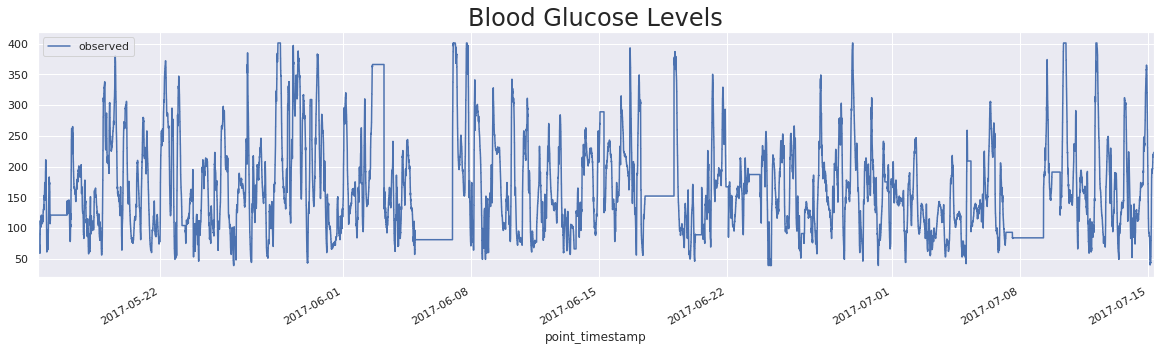

In [26]:
raw_bg_data.plot(figsize = (20, 5))
pyplot.title("Blood Glucose Levels", size = 24)
pyplot.show()

## Stationarity & ACF

In [27]:
#We use the Dickey-Fuller test to check for stationarity. 
#P value is 4.84e-25. Blood glucose data is stationary.
sts.adfuller(raw_bg_data.observed)

(-12.670079510402834,
 1.250053300034281e-23,
 25,
 87813,
 {'1%': -3.4304244706497498,
  '5%': -2.8615729148101225,
  '10%': -2.566787519410434},
 406750.40581544116)

Since the data is stationary, there is no need to transform the data.

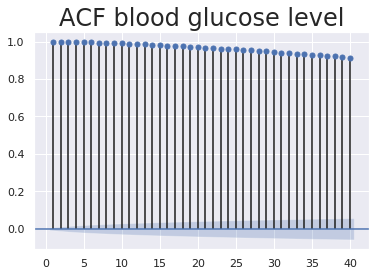

In [28]:
sgt.plot_acf(raw_bg_data.observed, lags = 40, zero = False)
plt.title("ACF blood glucose level", size = 24)
plt.show()

In [29]:
#Train-test split
size = int(len(X) * 0.55)
train, test = X[0:size], X[size:]


In [30]:
size = int(len(raw_bg_data)*0.55)
df, df_test = raw_bg_data.iloc[:size], raw_bg_data.iloc[size:]

## AR Model

In [44]:
model_ar = ARIMA(df.observed, order = (11,0,0))
results_ar = model_ar.fit()

In [45]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               observed   No. Observations:                48311
Model:                    ARMA(11, 0)   Log Likelihood             -115739.365
Method:                       css-mle   S.D. of innovations              2.656
Date:                Fri, 17 Jan 2020   AIC                         231504.730
Time:                        22:22:58   BIC                         231618.940
Sample:                    05-15-2017   HQIC                        231540.563
                         - 06-17-2017                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             170.1053     10.383     16.384      0.000     149.756     190.455
ar.L1.observed      0.9963      0.004    222.782      0.000       0.988       1.005
ar.L2.observed      0.0027      0.006      0.420      0.675      -0.010       0.015
ar.L3.observed   4.772e-06      0.006      0.001      0.999      -0.012       0.012
ar.L4.observed      0.0012      0.006      0.193      0.847      -0.011       0.014
ar.L5.observed      0.3679      0.006     58.254      0.000       0.356       0.380
ar.L6.observed     -0.3670      0.006    -58.107      0.000      -0.379      -0.355
ar.L7.observed     -0.0011      0.006     -0.181      0.857      -0.014       0.011
ar.L8.observed  -7.239e-06      0.006     -0.001      0.999      -0.012       0.012
ar.L9.observed      0.0039      0.006      0.613      0.540      -0.009       0.016
ar.L10.observed     0.1780      0.006     28.184      0.000       0.166       0.190
ar.L11.observed    -0.1829      0.004    -40.899      0.000      -0.192      -0.174
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -0.8834           -0.6405j            1.0912           -0.4002
AR.2            -0.8834           +0.6405j            1.0912            0.4002
AR.3            -1.2911           -0.0000j            1.2911           -0.5000
AR.4            -0.4020           -1.2253j            1.2896           -0.3005
AR.5            -0.4020           +1.2253j            1.2896            0.3005
AR.6             0.3350           -1.0368j            1.0896           -0.2003
AR.7             0.3350           +1.0368j            1.0896            0.2003
AR.8             1.0388           -0.7593j            1.2867           -0.1005
AR.9             1.0388           +0.7593j            1.2867            0.1005
AR.10            1.0027           -0.0000j            1.0027           -0.0000
AR.11            1.0849           -0.0000j            1.0849           -0.0000
------------------------------------------------------------------------------
"""

In [46]:
df.tail()

,observed
point_timestamp,
2017-06-17 20:57:22,152.0
2017-06-17 20:58:22,152.0
2017-06-17 20:59:22,152.0
2017-06-17 21:00:22,152.0
2017-06-17 21:01:22,152.0


In [47]:
#df_test.index

In [48]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error

start_date = '2017-06-17 21:02:22'
end_date = '2017-07-15 07:49:22'

In [49]:
end_date = "2019-10-23"
df_pred = results_ar.predict(start = start_date, end = end_date)

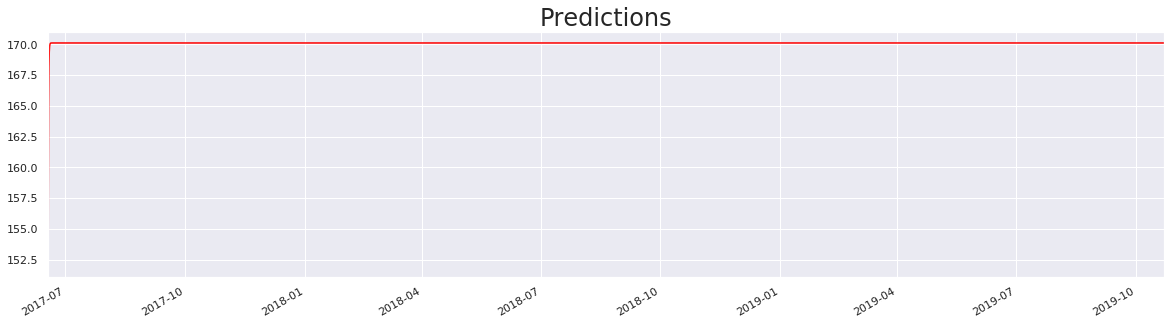

In [50]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
plt.title("Predictions", size = 24)
plt.show()

In [51]:
end_date = '2017-07-15 07:49:22'
df_pred = results_ar.predict(start = start_date, end = end_date)

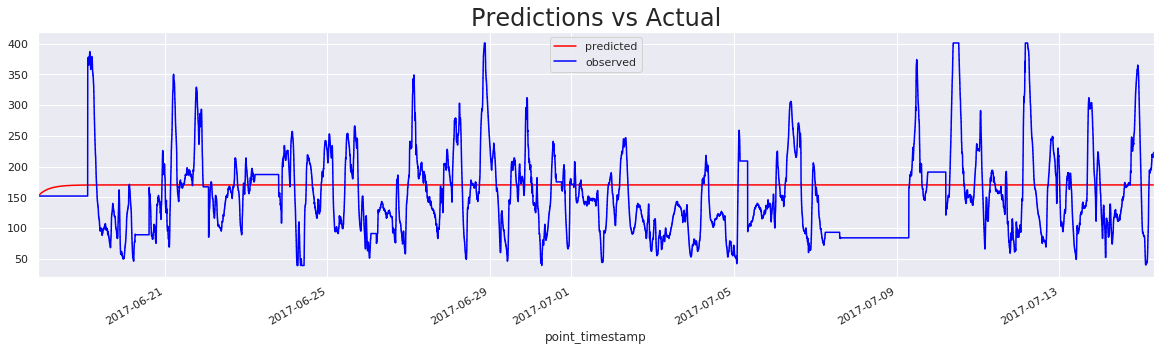

In [52]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red", label = 'predicted')
df_test.observed[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.legend()
plt.show()

In [53]:
df_test.observed

point_timestamp
2017-06-17 21:02:22    152.0
2017-06-17 21:03:22    152.0
2017-06-17 21:04:22    152.0
2017-06-17 21:05:22    152.0
2017-06-17 21:06:22    152.0
                       ...  
2017-07-15 07:45:22    223.0
2017-07-15 07:46:22    223.0
2017-07-15 07:47:22    223.0
2017-07-15 07:48:22    223.0
2017-07-15 07:49:22    223.0
Freq: T, Name: observed, Length: 39528, dtype: float64

In [56]:
forecast_errors_AR = [df_pred[i]-df_test.observed[i] for i in range(len(df_pred))]
bias_AR = sum(forecast_errors_AR) * 1.0/len(df_pred)
print('Bias for AR model: %f' % bias_AR)
mae_AR = mean_absolute_error(df_pred, df_test.observed)
print('MAE for AR model: %f' % mae_AR)
mse_AR = mean_squared_error(df_pred, df_test.observed)
print('MSE for AR model: %f' % mse_AR)
rmse_AR = sqrt(mse_AR)
print('RMSE for AR model: %f' % rmse_AR)

Bias for AR model: 17.088497
MAE for AR model: 55.458207
MSE for AR model: 4865.207878
RMSE for AR model: 69.751042


## MA

In [57]:
model_ma = ARIMA(df.observed, order = (0,0,3))
results_ma = model_ma.fit()

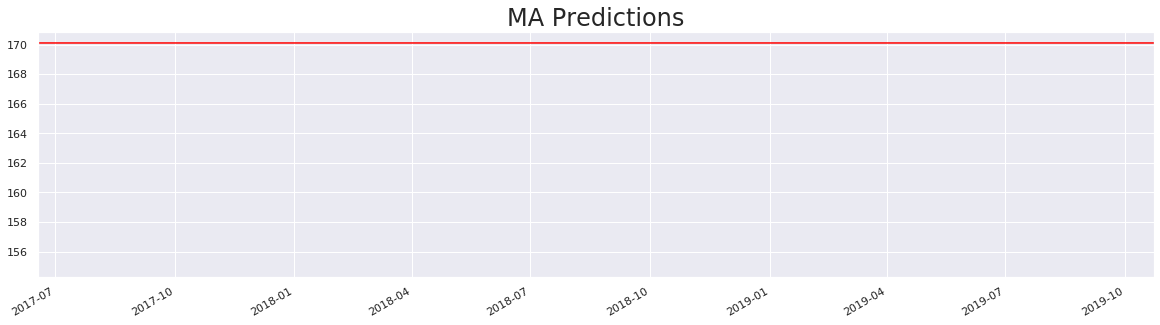

In [58]:
start_date = '2017-06-17 21:02:22'
end_date = '2017-07-15 07:49:22'
end_date = "2019-10-23"
df_pred_ma = results_ma.predict(start = start_date, end = end_date)
df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")
plt.title("MA Predictions", size = 24)
plt.show()

In [59]:
end_date = '2017-07-15 07:49:22'
df_pred_ma = results_ma.predict(start = start_date, end = end_date)

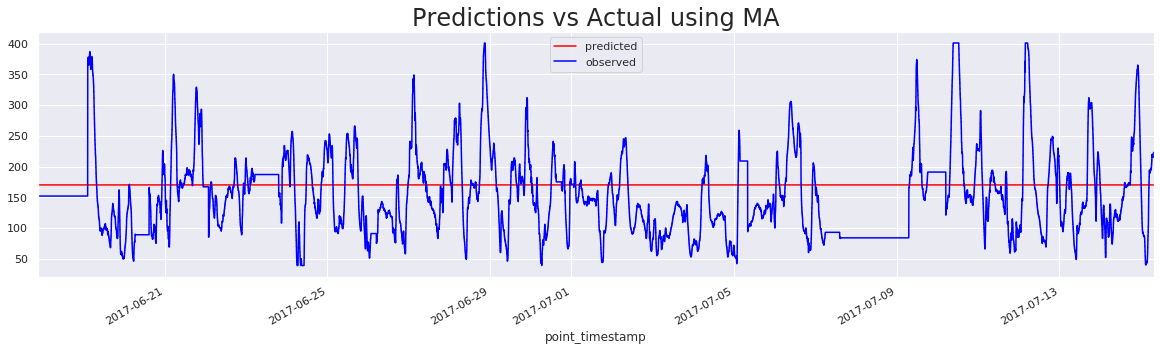

In [60]:
df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red", label = 'predicted')
df_test.observed[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual using MA", size = 24)
plt.legend()
plt.show()

In [62]:
forecast_errors_MA = [df_pred_ma[i]-df_test.observed[i] for i in range(len(df_pred_ma))]
bias_ma = sum(forecast_errors_MA) * 1.0/len(df_pred_ma)
print('Bias for MA model: %f' % bias_ma)
mae_ma = mean_absolute_error(df_pred_ma, df_test.observed)
print('MAE for MA model: %f' % mae_ma)
mse_ma = mean_squared_error(df_pred_ma, df_test.observed)
print('MSE for MA model: %f' % mse_ma)
rmse_ma = sqrt(mse_ma)
print('RMSE for MA model: %f' % rmse_ma)

Bias for MA model: 17.260950
MAE for MA model: 55.629550
MSE for MA model: 4869.594182
RMSE for MA model: 69.782478


## ARMA

In [63]:
model_ar_5_ma_6 = ARIMA(df.observed, order = (5,0,6))
results_ar_5_ma_6 = model_ar_5_ma_6.fit()
results_ar_5_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               observed   No. Observations:                48311
Model:                     ARMA(5, 6)   Log Likelihood             -117108.590
Method:                       css-mle   S.D. of innovations              2.732
Date:                Fri, 17 Jan 2020   AIC                         234243.181
Time:                        23:15:20   BIC                         234357.391
Sample:                    05-15-2017   HQIC                        234279.014
                         - 06-17-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            170.1054      8.081     21.050      0.000     154.267     185.944
ar.L1.observed     1.8565      0.007    251.925      0.000       1.842       1.871
ar.L2.observed    -1.2347      0.017    -74.014      0.000      -1.267      -1.202
ar.L3.observed     0.2746      0.020     13.660      0.000       0.235       0.314
ar.L4.observed     0.6584      0.019     34.710      0.000       0.621       0.696
ar.L5.observed    -0.5551      0.009    -64.039      0.000      -0.572      -0.538
ma.L1.observed    -0.8941      0.008   -110.169      0.000      -0.910      -0.878
ma.L2.observed     0.4048      0.011     37.647      0.000       0.384       0.426
ma.L3.observed     0.1323      0.011     11.954      0.000       0.111       0.154
ma.L4.observed    -0.5881      0.010    -59.876      0.000      -0.607      -0.569
ma.L5.observed     0.3236      0.005     60.416      0.000       0.313       0.334
ma.L6.observed    -0.1833      0.005    -37.386      0.000      -0.193      -0.174
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.4961           -0.0000j            1.4961           -0.5000
AR.2            0.3246           -1.0296j            1.0795           -0.2014
AR.3            0.3246           +1.0296j            1.0795            0.2014
AR.4            1.0051           -0.0000j            1.0051           -0.0000
AR.5            1.0279           -0.0000j            1.0279           -0.0000
MA.1           -1.1831           -0.0000j            1.1831           -0.5000
MA.2            1.1085           -0.0000j            1.1085           -0.0000
MA.3            0.1838           -1.3225j            1.3352           -0.2280
MA.4            0.1838           +1.3225j            1.3352            0.2280
MA.5            0.7360           -1.3383j            1.5274           -0.1700
MA.6            0.7360           +1.3383j            1.5274            0.1700
-----------------------------------------------------------------------------
"""

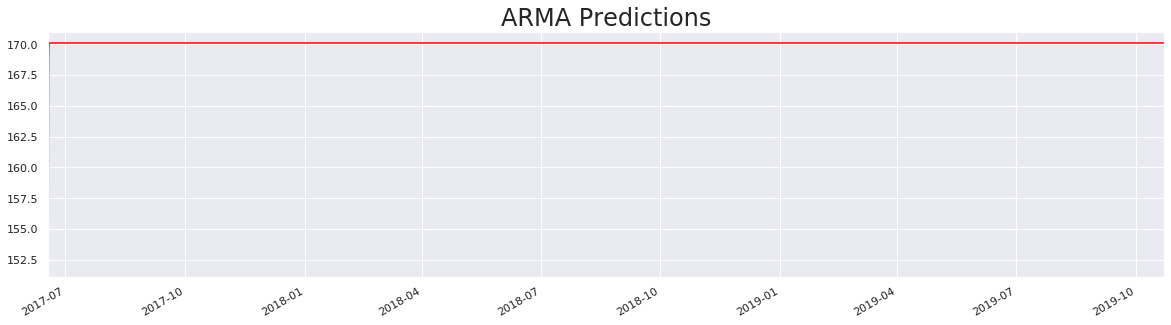

In [64]:
start_date = '2017-06-17 21:02:22'
end_date = '2017-07-15 07:49:22'
end_date = "2019-10-23"
df_pred_ar_5_ma_6 = results_ar_5_ma_6.predict(start = start_date, end = end_date)
df_pred_ar_5_ma_6[start_date:end_date].plot(figsize = (20,5), color = "red")
plt.title("ARMA Predictions", size = 24)
plt.show()

In [65]:
end_date = '2017-07-15 07:49:22'
df_pred_arma = results_ma.predict(start = start_date, end = end_date)

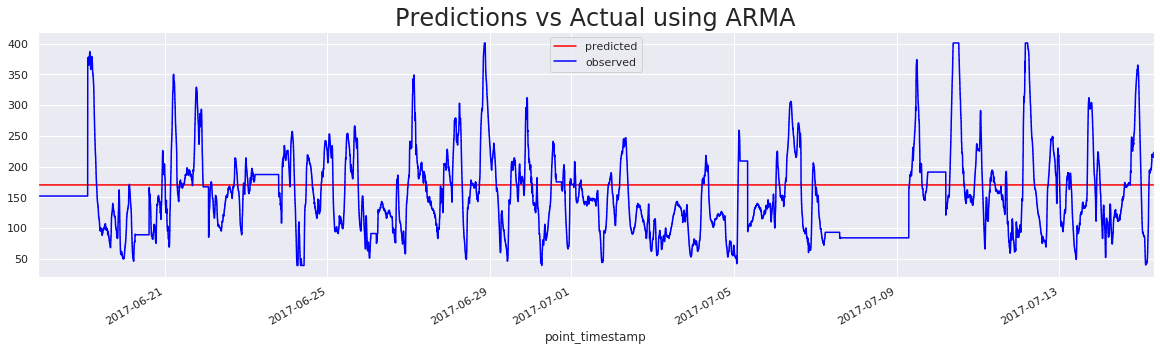

In [66]:
df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red", label = 'predicted')
df_test.observed[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual using ARMA", size = 24)
plt.legend()
plt.show()

ARMA gives a straight line yet again. This suggests blood glucose is always stable.

In [68]:
forecast_errors_ARMA = [df_pred_arma[i]-df_test.observed[i] for i in range(len(df_pred_arma))]
bias_arma = sum(forecast_errors_ARMA) * 1.0/len(df_pred_arma)
print('Bias for ARMA model: %f' % bias_arma)
mae_arma = mean_absolute_error(df_pred_arma, df_test.observed)
print('MAE for ARMA model: %f' % mae_arma)
mse_arma = mean_squared_error(df_pred_arma, df_test.observed)
print('MSE for ARMA model: %f' % mse_ma)
rmse_arma = sqrt(mse_arma)
print('RMSE for ARMA model: %f' % rmse_arma)

Bias for ARMA model: 17.260950
MAE for ARMA model: 55.629550
MSE for ARMA model: 4869.594182
RMSE for ARMA model: 69.782478


## ARIMAX

In [69]:
df_bg_synced_train['ret_bg'] = df_bg_synced_train.bg_level.pct_change(1).mul(100)

/project/6003019/sergei/tfnew/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [70]:
df_exog_train.head()

,point_timestamp,distance,heartrate
bg_time,,,
2017-05-16 22:16:22,2017-05-16 22:15:44,0.0,98.0
2017-05-16 22:17:22,2017-05-16 22:16:44,0.0,104.0
2017-05-16 22:18:22,2017-05-16 22:17:44,0.0,110.0
2017-05-16 22:19:22,2017-05-16 22:18:44,0.0,112.0
2017-05-16 22:20:22,2017-05-16 22:19:44,0.0,97.0


In [71]:
df_exog_train['ret_hr'] = df_exog_train.heartrate.pct_change(1).mul(100)

/project/6003019/sergei/tfnew/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
#Set the datetime as the index of the dataframe
df_bg_synced_train.set_index("point_timestamp", inplace = True)

In [73]:
model_ar_5_i_1_ma_5_Xhr = ARIMA(df_bg_synced_train.ret_bg[1:], exog = df_exog_train[['ret_hr']][1:], order=(5,1,5))
results_ar_5_i_1_ma_5_Xhr = model_ar_5_i_1_ma_5_Xhr.fit()

/project/6003019/sergei/tfnew/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/project/6003019/sergei/tfnew/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)


In [74]:
df_bg_synced_train.tail()

,bg_level,ret_bg
point_timestamp,,
2017-06-18 06:21:22,152.0,0.0
2017-06-18 06:22:22,152.0,0.0
2017-06-18 06:23:22,152.0,0.0
2017-06-18 06:24:22,152.0,0.0
2017-06-18 06:25:22,152.0,0.0


In [75]:
df_exog_train.tail()

,point_timestamp,distance,heartrate,ret_hr
bg_time,,,,
2017-06-18 06:21:22,2017-06-18 06:20:44,0.00621,75.0,0.0
2017-06-18 06:22:22,2017-06-18 06:21:44,0.00621,75.0,0.0
2017-06-18 06:23:22,2017-06-18 06:22:44,0.00022,75.0,0.0
2017-06-18 06:24:22,2017-06-18 06:23:44,0.00022,75.0,0.0
2017-06-18 06:25:22,2017-06-18 06:24:44,0.00022,75.0,0.0


In [76]:
results_ar_5_i_1_ma_5_Xhr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.ret_bg   No. Observations:                46568
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -95674.896
Method:                       css-mle   S.D. of innovations              1.888
Date:                Fri, 17 Jan 2020   AIC                         191375.792
Time:                        23:24:39   BIC                         191489.525
Sample:                    05-16-2017   HQIC                        191411.537
                         - 06-18-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0004      0.001      0.545      0.585      -0.001       0.002
ret_hr            -0.0048      0.001     -3.982      0.000      -0.007      -0.002
ar.L1.D.ret_bg    -0.7786      0.026    -30.344      0.000      -0.829      -0.728
ar.L2.D.ret_bg    -0.7409      0.024    -30.891      0.000      -0.788      -0.694
ar.L3.D.ret_bg    -0.7019      0.022    -32.499      0.000      -0.744      -0.660
ar.L4.D.ret_bg    -0.6584      0.019    -35.087      0.000      -0.695      -0.622
ar.L5.D.ret_bg     0.1020      0.015      6.988      0.000       0.073       0.131
ma.L1.D.ret_bg    -0.2038      0.025     -8.052      0.000      -0.253      -0.154
ma.L2.D.ret_bg    -0.0303      0.009     -3.531      0.000      -0.047      -0.013
ma.L3.D.ret_bg    -0.0338      0.009     -3.937      0.000      -0.051      -0.017
ma.L4.D.ret_bg    -0.0371      0.009     -4.062      0.000      -0.055      -0.019
ma.L5.D.ret_bg    -0.3693      0.009    -42.689      0.000      -0.386      -0.352
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8668           -0.6340j            1.0739           -0.3995
AR.2           -0.8668           +0.6340j            1.0739            0.3995
AR.3            0.3345           -1.0093j            1.0633           -0.1991
AR.4            0.3345           +1.0093j            1.0633            0.1991
AR.5            7.5219           -0.0000j            7.5219           -0.0000
MA.1            1.1134           -0.0000j            1.1134           -0.0000
MA.2            0.4120           -1.1486j            1.2203           -0.1952
MA.3            0.4120           +1.1486j            1.2203            0.1952
MA.4           -1.0189           -0.7713j            1.2779           -0.3969
MA.5           -1.0189           +0.7713j            1.2779            0.3969
-----------------------------------------------------------------------------
"""

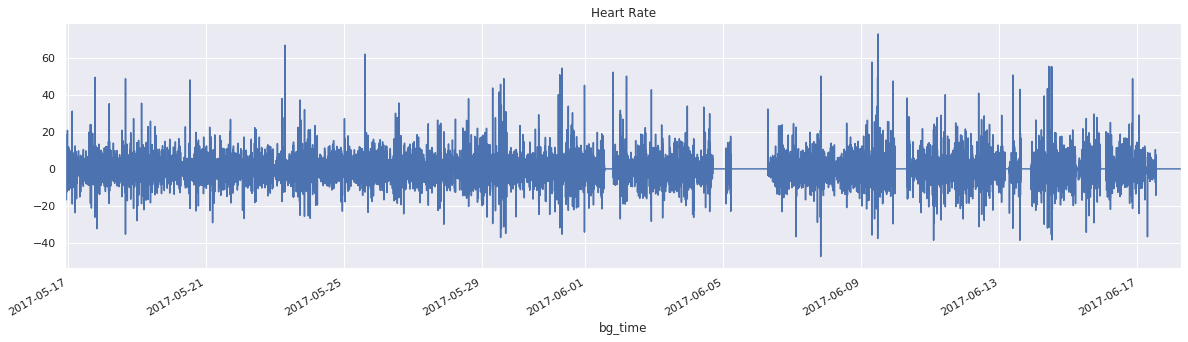

In [77]:
#Visualization of heart rate data
df_exog_train['ret_hr'].plot(figsize = (20, 5), title = "Heart Rate")
plt.show()

In [78]:
df_exog.iloc[46006:]

,point_timestamp,distance,heartrate
bg_time,,,
2017-06-17 21:02:22,2017-06-17 21:01:44,0.00000,75.0
2017-06-17 21:03:22,2017-06-17 21:02:44,0.00752,75.0
2017-06-17 21:04:22,2017-06-17 21:03:44,0.00752,75.0
2017-06-17 21:05:22,2017-06-17 21:04:44,0.00752,75.0
2017-06-17 21:06:22,2017-06-17 21:05:44,0.00822,75.0
...,...,...,...
2017-07-14 17:24:22,2017-07-14 17:23:44,0.00000,74.0
2017-07-14 17:25:22,2017-07-14 17:24:44,0.00000,76.0
2017-07-14 17:26:22,2017-07-14 17:25:44,0.00000,71.0


In [79]:
df_exog_chopped = df_exog.iloc[46006:]
df_exog_chopped.head(10)

,point_timestamp,distance,heartrate
bg_time,,,
2017-06-17 21:02:22,2017-06-17 21:01:44,0.00000,75.0
2017-06-17 21:03:22,2017-06-17 21:02:44,0.00752,75.0
2017-06-17 21:04:22,2017-06-17 21:03:44,0.00752,75.0
2017-06-17 21:05:22,2017-06-17 21:04:44,0.00752,75.0
2017-06-17 21:06:22,2017-06-17 21:05:44,0.00822,75.0
2017-06-17 21:07:22,2017-06-17 21:06:44,0.00822,75.0
2017-06-17 21:08:22,2017-06-17 21:07:44,0.00822,75.0
2017-06-17 21:09:22,2017-06-17 21:08:44,0.00822,75.0
2017-06-17 21:10:22,2017-06-17 21:09:44,0.00822,75.0


In [80]:
df_exog_chopped['ret_hr'] = df_exog_chopped.heartrate.pct_change(1).mul(100)

/project/6003019/sergei/tfnew/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [81]:
df_exog['ret_hr'] = df_exog.heartrate.pct_change(1).mul(100)

In [82]:
df_test['ret_bg'] = df_test.observed.pct_change(1).mul(100)

/project/6003019/sergei/tfnew/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


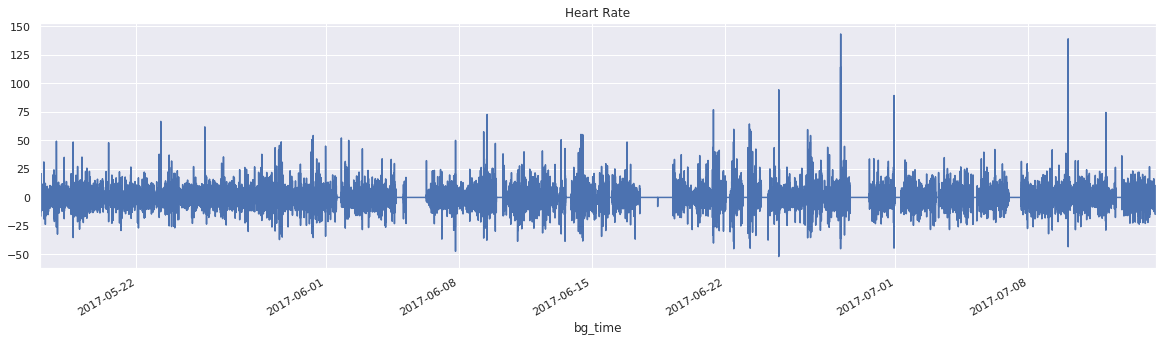

In [83]:
#Visualization of heart rate data
df_exog['ret_hr'].plot(figsize = (20, 5), title = "Heart Rate")
plt.show()

In [84]:
start_date = '2017-06-17 21:02:22'
end_date = '2017-07-14 17:28:22'
df_pred_armax = results_ar_5_i_1_ma_5_Xhr.predict(start = start_date, end = end_date, exog = df_exog[['ret_hr']][start_date:end_date]) 


In [85]:
df_pred_armax.head(1000)

2017-06-17 21:02:22    0.004825
2017-06-17 21:03:22    0.004825
2017-06-17 21:04:22    0.004825
2017-06-17 21:05:22    0.004825
2017-06-17 21:06:22    0.004825
                         ...   
2017-06-18 13:37:22    0.000416
2017-06-18 13:38:22    0.000416
2017-06-18 13:39:22    0.000416
2017-06-18 13:40:22    0.000416
2017-06-18 13:41:22    0.000416
Freq: T, Length: 1000, dtype: float64

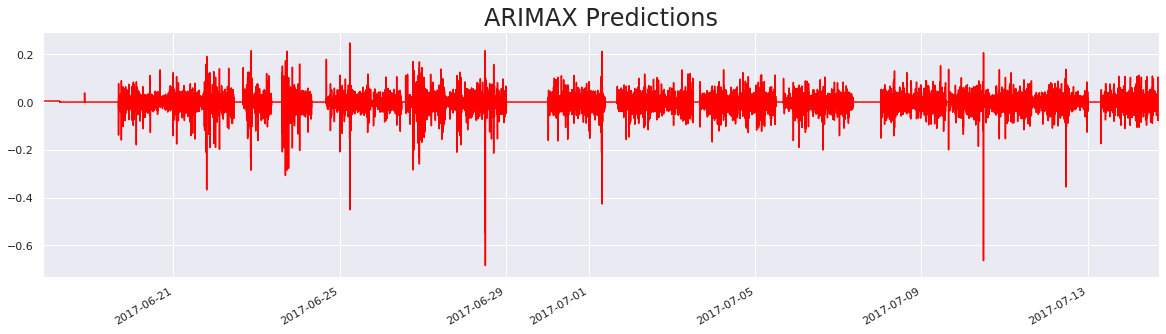

In [86]:
df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
plt.title("ARIMAX Predictions", size = 24)
plt.show()

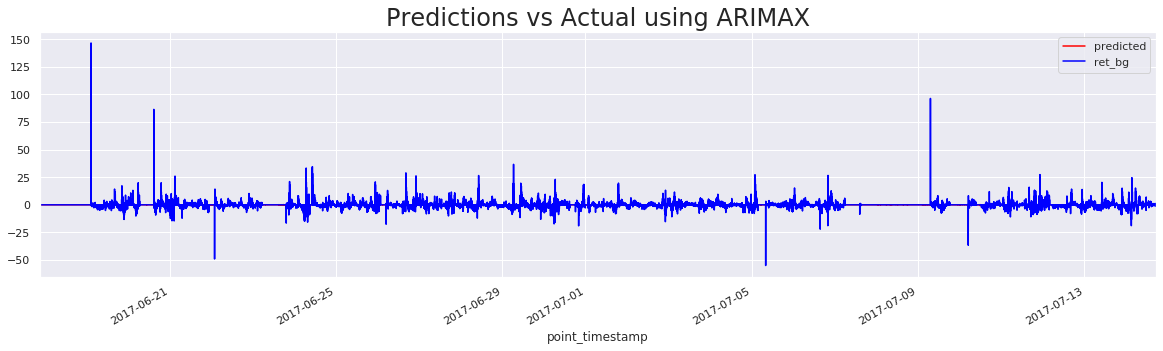

In [87]:
df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red", label = 'predicted')
df_test.ret_bg[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual using ARIMAX", size = 24)
plt.legend()
plt.show()

In [89]:
forecast_errors_arimax = [df_pred_armax[i]-df_test.observed[i] for i in range(len(df_pred_armax))]
bias_armax = sum(forecast_errors_arimax) * 1.0/len(df_pred_armax)
print('Bias for ARMAX model: %f' % bias_armax)
mae_armax = mean_absolute_error(df_pred_armax[start_date:end_date], df_test.observed[start_date:end_date])
print('MAE for ARMAX model: %f' % mae_armax)
mse_armax = mean_squared_error(df_pred_armax[start_date:end_date], df_test.observed[start_date:end_date])
print('MSE for ARMAX model: %f' % mse_armax)
rmse_armax = sqrt(mse_armax)
print('RMSE for ARMAX model: %f' % rmse_armax)

Bias for ARMAX model: -151.874423
MAE for ARMAX model: 151.874423
MSE for ARMAX model: 27501.137659
RMSE for ARMAX model: 165.834670


## SARMA

In [98]:
model_ret_sarma = SARIMAX(df_bg_synced_train.ret_bg[1:], order=(5,1,5), seasonal_order = (2,0,2,12))
results_model_ret_sarma = model_ret_sarma.fit()

/project/6003019/sergei/tfnew/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  % freq, ValueWarning)
/project/6003019/sergei/tfnew/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [100]:
start_date = '2017-06-17 21:02:22'
end_date = '2017-07-14 17:28:22'
df_pred_sarma = results_model_ret_sarma.predict(start = start_date, end = end_date) 


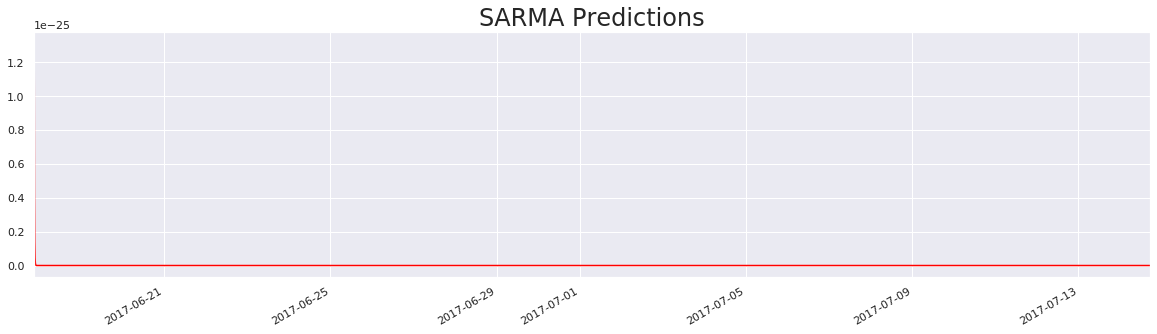

In [101]:
df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
plt.title("SARMA Predictions", size = 24)
plt.show()

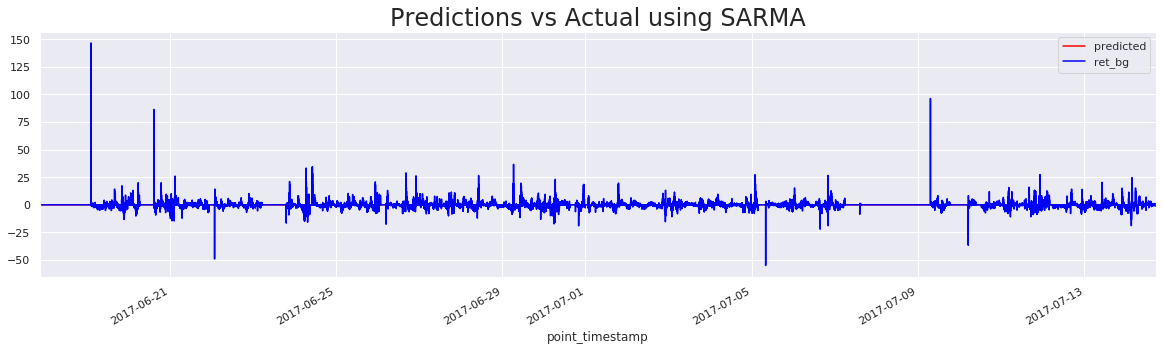

In [102]:
df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red", label = 'predicted')
df_test.ret_bg[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual using SARMA", size = 24)
plt.legend()
plt.show()

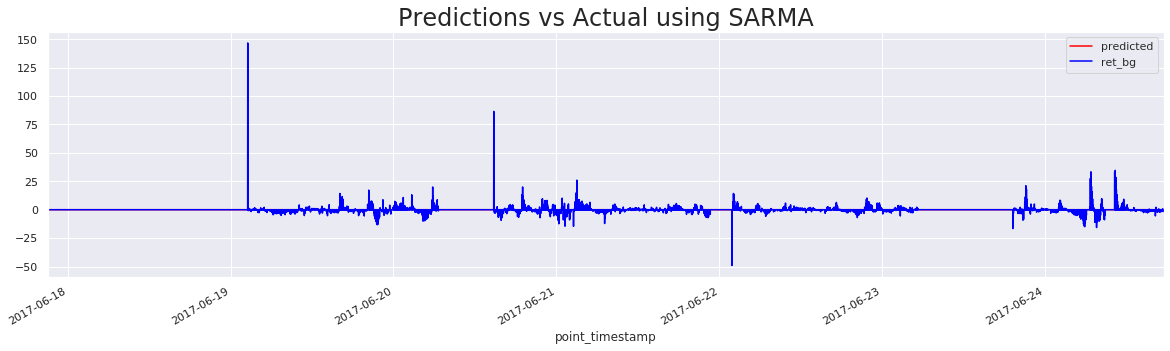

In [105]:
start_date = '2017-06-17 21:02:22'
end_date = '2017-06-24 17:28:22'

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red", label = 'predicted')
df_test.ret_bg[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual using SARMA", size = 24)
plt.legend()
plt.show()

In [103]:
forecast_errors_sarma = [df_pred_sarma[i]-df_test.observed[i] for i in range(len(df_pred_sarma))]
bias_sarma = sum(forecast_errors_sarma) * 1.0/len(df_pred_sarma)
print('Bias for SARMA model: %f' % bias_sarma)
mae_sarma = mean_absolute_error(df_pred_sarma[start_date:end_date], df_test.observed[start_date:end_date])
print('MAE for SARMA model: %f' % mae_sarma)
mse_sarma = mean_squared_error(df_pred_sarma[start_date:end_date], df_test.observed[start_date:end_date])
print('MSE for SARMA model: %f' % mse_sarma)
rmse_sarma = sqrt(mse_sarma)
print('RMSE for SARMA model: %f' % rmse_sarma)

Bias for SARMA model: -151.874415
MAE for SARMA model: 151.874415
MSE for SARMA model: 27501.127525
RMSE for SARMA model: 165.834639


### Final comparisons of RMSE errors

In [106]:
print('RMSE for AR model: %f' % rmse_AR)
print('RMSE for MA model: %f' % rmse_ma)
print('RMSE for ARMA model: %f' % rmse_arma)
print('RMSE for ARMAX model: %f' % rmse_armax)
print('RMSE for SARMA model: %f' % rmse_sarma)

RMSE for AR model: 69.751042
RMSE for MA model: 69.782478
RMSE for ARMA model: 69.782478
RMSE for ARMAX model: 165.834670
RMSE for SARMA model: 165.834639


Clearly, none of the simple models are good predictors. A more complicated model, such as RNN with LSTM units should be tried next.